In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
IMAGE_SIZE = 216

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout , BatchNormalization

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5500)])
  except RuntimeError as e:
    print(e)

In [8]:
Dataset_Path = os.getcwd() + '/inaturalist_12K'
labels = ["Amphibia","Animalia","Arachnida","Aves","Fungi","Insecta","Mammalia","Mollusca","Plantae","Reptilia"]
DATSET_SIZE = 10000

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import cv2
import csv
import PIL


# Dataset_Path = '/content/drive/MyDrive/inaturalist_12K'
train_path = os.path.join(Dataset_Path , 'train')
test_path = os.path.join(Dataset_Path , 'val')
# test_path1 = test_path
test_path1 = 'D:/val'

In [10]:
import pathlib
Dataset_Path = pathlib.Path(Dataset_Path)
train_path = pathlib.Path(train_path)
test_path = pathlib.Path(test_path)

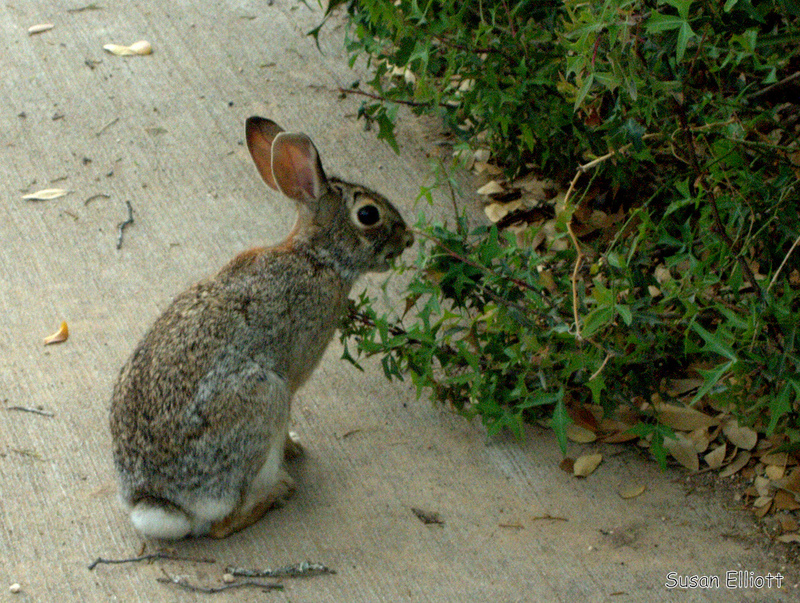

In [11]:
Mammals = list(train_path.glob('Mammalia/*'))
PIL.Image.open(str(Mammals[0]))

In [12]:
# Preprocessing

In [13]:
batch_size = 64

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path, 
    class_names=None, 
    color_mode='rgb', 
    batch_size=batch_size, 
    image_size=(IMAGE_SIZE,IMAGE_SIZE), 
    shuffle=True, 
    seed=1234, 
    validation_split=0.1,
    subset="training",
    interpolation='bilinear'
)

Found 9999 files belonging to 10 classes.
Using 9000 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path, 
    class_names=None, 
    color_mode='rgb', 
    batch_size=batch_size, 
    image_size=(IMAGE_SIZE,IMAGE_SIZE), 
    shuffle=True, 
    seed=1234, 
    validation_split=0.1,
    subset="validation",
    interpolation='bilinear'
)

Found 9999 files belonging to 10 classes.
Using 999 files for validation.


In [16]:
type(train_ds)
type(val_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [17]:
class_names = train_ds.class_names
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


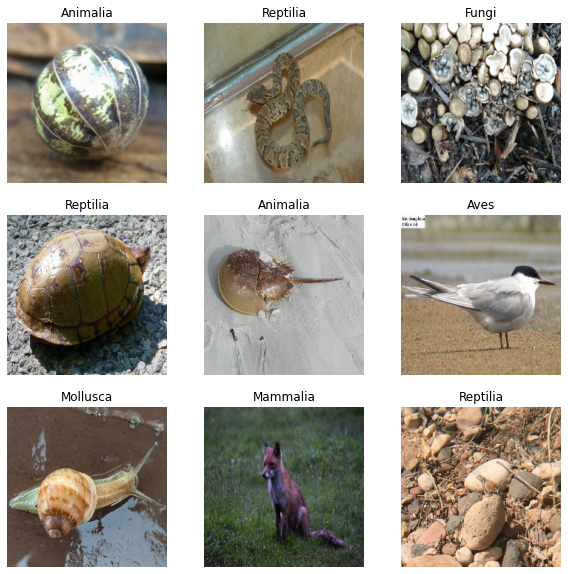

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
from keras.layers import experimental

In [21]:
## Wandb sweep

In [22]:
#### Install and login

In [23]:
import wandb
from wandb.keras import WandbCallback
wandb.login(key="866040d7d81f67025d43e7d50ecd83d54b6cf977", relogin=False)

wandb: Currently logged in as: mooizz (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Jaitesh/.netrc


True

In [24]:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [16,32]
        },
        'num_fliters': {  
            'values': [16,48]
        },
        'filter_size':{
            'values': [3]
        },
        'filter_org': {
            'values': ['same']
        },
        'data_aug': {
            'values': ['yes']
        },
        'dropout':{
            'values': [0.01,0.1]
        },
        'batch_norm':{
            'values' : ['yes']
        }
    }
}

In [25]:
sweep_id = wandb.sweep(sweep_config, entity="mooizz",project="conv_inaturalist")

Create sweep with ID: zdt2hi01
Sweep URL: https://wandb.ai/mooizz/conv_inaturalist/sweeps/zdt2hi01


In [26]:
data_augmentation = Sequential(
  [
    experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(IMAGE_SIZE, 
                                                              IMAGE_SIZE,
                                                              3)),
    experimental.preprocessing.RandomRotation(0.3),
    experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [27]:
def getModel(numFilters, filterSize,filterConf,dropout,data_aug, batch_norm):
    model = Sequential()
    if data_aug == 'yes':
        model.add(data_augmentation)
    input_shape1 = (IMAGE_SIZE, IMAGE_SIZE, 3)
    model.add(experimental.preprocessing.Rescaling(1./255, input_shape=input_shape1))
    model.add(Conv2D(numFilters, (filterSize, filterSize), input_shape=input_shape1))
    if batch_norm == 'yes':
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))        

    for l in range(4):
        if filterConf == 'double':
            numFilters = numFilters * 2
        if filterConf == 'half':
            numFilters = numFilters / 2
        model.add(Conv2D(numFilters, (filterSize, filterSize)))
        if batch_norm == 'yes':
            model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [28]:
def train():
    config_defaults = {
        'epochs' : 22,
        'batch_size' : 64,
        'optimizer' : 'adam',
        'filter_org' : 'same',
        'num_filters' : 64,
        'filter_size' : 5,
        'dropout' : 0.2,
        'data_aug' : 'yes',
         'batch_norm' : 'yes'
    }
    wandb.init(config=config_defaults)
    config = wandb.config
    model = getModel(config.num_filters,config.filter_size,config.filter_org,
                     config.dropout, config.data_aug, config.batch_norm)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
    model.fit(train_ds,
          epochs=config.epochs,
          validation_data=val_ds,
          verbose=1,
             callbacks=[WandbCallback()])
   

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: o0mxa3mw with config:
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dropout: 0.01
wandb: 	epochs: 16
wandb: 	filter_org: same
wandb: 	filter_size: 3
wandb: 	num_fliters: 16


Epoch 1/16
141/141 [==============================] - 47s 284ms/step - loss: 2.3292 - accuracy: 0.1936 - val_loss: 2.5192 - val_accuracy: 0.0951
Epoch 2/16
141/141 [==============================] - 12s 83ms/step - loss: 2.0088 - accuracy: 0.2782 - val_loss: 2.5675 - val_accuracy: 0.1391
Epoch 3/16
141/141 [==============================] - 12s 83ms/step - loss: 1.9552 - accuracy: 0.3046 - val_loss: 2.1172 - val_accuracy: 0.2152
Epoch 4/16
141/141 [==============================] - 12s 83ms/step - loss: 1.9081 - accuracy: 0.3182 - val_loss: 1.9801 - val_accuracy: 0.2853
Epoch 5/16
141/141 [==============================] - 12s 83ms/step - loss: 1.8771 - accuracy: 0.3335 - val_loss: 2.0052 - val_accuracy: 0.2973
Epoch 6/16
141/141 [==============================] - 12s 83ms/step - loss: 1.8541 - accuracy: 0.3459 - val_loss: 2.1296 - val_accuracy: 0.2693
Epoch 7/16
141/141 [==============================] - 12s 84ms/step - loss: 1.8231 - accuracy: 0.3512 - val_loss: 2.1967 - val_accuracy

epoch,15
loss,1.61063
accuracy,0.43344
val_loss,2.13903
val_accuracy,0.33433
_runtime,233
_timestamp,1618162494
_step,15
best_val_loss,1.9647
best_epoch,14


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
accuracy,▁▃▄▄▅▅▅▆▆▇▇▇▇███
val_loss,▇█▃▁▁▃▄▅▆▆▃▅▄▅▁▃
val_accuracy,▁▂▅▇▇▆▆▆▅▆█▆█▇██
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇█
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇█
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 88slulmu with config:
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dropout: 0.01
wandb: 	epochs: 16
wandb: 	filter_org: same
wandb: 	filter_size: 3
wandb: 	num_fliters: 48


Epoch 1/16
141/141 [==============================] - 13s 87ms/step - loss: 2.3020 - accuracy: 0.2027 - val_loss: 2.4839 - val_accuracy: 0.0951
Epoch 2/16
141/141 [==============================] - 12s 86ms/step - loss: 2.0056 - accuracy: 0.2800 - val_loss: 2.4405 - val_accuracy: 0.1431
Epoch 3/16
141/141 [==============================] - 12s 83ms/step - loss: 1.9610 - accuracy: 0.2950 - val_loss: 2.1797 - val_accuracy: 0.2152
Epoch 4/16
141/141 [==============================] - 12s 84ms/step - loss: 1.9040 - accuracy: 0.3247 - val_loss: 1.9953 - val_accuracy: 0.2883
Epoch 5/16
141/141 [==============================] - 12s 85ms/step - loss: 1.8636 - accuracy: 0.3416 - val_loss: 2.0759 - val_accuracy: 0.2843
Epoch 6/16
141/141 [==============================] - 12s 85ms/step - loss: 1.8405 - accuracy: 0.3451 - val_loss: 1.9291 - val_accuracy: 0.3213
Epoch 7/16
141/141 [==============================] - 12s 82ms/step - loss: 1.7995 - accuracy: 0.3525 - val_loss: 2.2813 - val_accuracy:

epoch,15
loss,1.5933
accuracy,0.44211
val_loss,1.90979
val_accuracy,0.33834
_runtime,197
_timestamp,1618162737
_step,15
best_val_loss,1.90979
best_epoch,15


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁
accuracy,▁▃▃▄▅▅▅▆▇▇▇▇▇███
val_loss,█▇▄▂▃▁▆▄▃▂▃▄▃▁▂▁
val_accuracy,▁▂▄▇▆▇▆▇▇█▇▇████
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: llhhl5jn with config:
wandb: 	batch_norm: yes
wandb: 	data_aug: yes
wandb: 	dropout: 0.1
wandb: 	epochs: 32
wandb: 	filter_org: same
wandb: 	filter_size: 3
wandb: 	num_fliters: 48


Epoch 1/32
141/141 [==============================] - 13s 84ms/step - loss: 2.3499 - accuracy: 0.1938 - val_loss: 2.5400 - val_accuracy: 0.0941
Epoch 2/32
141/141 [==============================] - 12s 83ms/step - loss: 2.0230 - accuracy: 0.2740 - val_loss: 2.5817 - val_accuracy: 0.1191
Epoch 3/32
141/141 [==============================] - 12s 83ms/step - loss: 1.9618 - accuracy: 0.3061 - val_loss: 2.2207 - val_accuracy: 0.1822
Epoch 4/32
141/141 [==============================] - 12s 83ms/step - loss: 1.9203 - accuracy: 0.3129 - val_loss: 1.9898 - val_accuracy: 0.2803
Epoch 5/32
141/141 [==============================] - 12s 83ms/step - loss: 1.8875 - accuracy: 0.3241 - val_loss: 2.0525 - val_accuracy: 0.2733
Epoch 6/32
141/141 [==============================] - 12s 84ms/step - loss: 1.8548 - accuracy: 0.3373 - val_loss: 2.0220 - val_accuracy: 0.3123
Epoch 7/32
141/141 [==============================] - 12s 83ms/step - loss: 1.8265 - accuracy: 0.3559 - val_loss: 2.0645 - val_accuracy:

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()